In [ ]:
!pip install binclass-tools

In [129]:
!pip install causalml

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *


ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


Primeramente realizaremos la separación en train y test:

In [131]:

data = pd.read_parquet('/student_performance.parquet', engine='pyarrow')
# Convertir la variable objetivo a numérica
data['target'] = data['target'].map({'Aprobado': 1, 'Suspenso': 0})
data["treatment"] = data["ParentalSupport"] > 3

# Definir características (X) y variable objetivo (y)
X = data.drop(columns=['StudentID', 'target'])
y = data['target']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

# Mostrar la cantidad de muestras en cada conjunto
(X_train.shape, X_test.shape), (y_train.value_counts(), y_test.value_counts())


(((1794, 13), (598, 13)),
 (target
  1    1512
  0     282
  Name: count, dtype: int64,
  target
  1    504
  0     94
  Name: count, dtype: int64))

# Exploración de datos
Ahora haremos un análisis exploratorio basico

In [14]:
data

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,target
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,1
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,3388,18,1,0,3,10.680555,2,0,4,1,0,0,0,1
2388,3389,17,0,0,1,7.583217,4,1,4,0,1,0,0,0
2389,3390,16,1,0,2,6.805500,20,0,2,0,0,0,1,0
2390,3391,16,1,1,0,12.416653,17,0,2,0,1,1,0,1


In [73]:
print("Numero de estudiantes, numero y porcentaje de ausencias por calificación")
data.groupby("target")["Absences"].agg(["count","sum","mean"])

Numero de estudiantes, numero y porcentaje de ausencias por calificación


,count,sum,mean
target,,,
0,376,2044,5.436170
1,2016,32739,16.239583


En este caso vemos como aquellos alumnos que han aprobado, han tenido un mayor número de ausencias de media. A continuación graficaremos las distribuciones acumuladas:

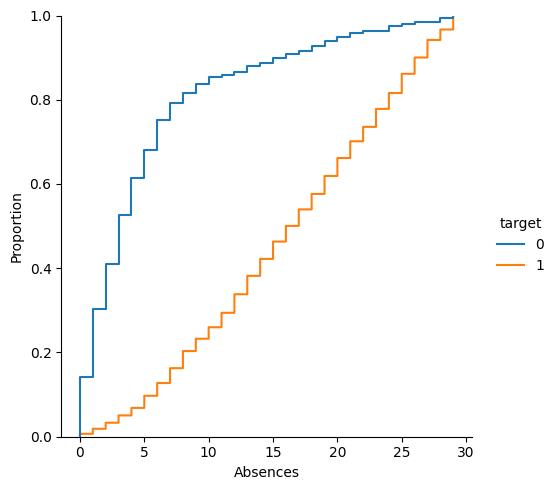

In [87]:
sns.displot(data = data, x = "Absences", hue = "target", kind = "ecdf")

In [88]:
print("Numero de estudiantes, numero de aprobados y porcentaje de aprobados por nivel educativo de los padres")
data.groupby("ParentalEducation")["target"].agg(["count","sum","mean"])

Numero de estudiantes, numero de aprobados y porcentaje de aprobados por nivel educativo de los padres


,count,sum,mean
ParentalEducation,,,
0,243,205,0.843621
1,728,613,0.842033
2,934,778,0.832976
3,367,311,0.847411
4,120,109,0.908333


No parece que haya una gran diferencia en base al nivel educativo de los padres, salvo para aquellos cuyos padres tienen un titulo superior (con un 90% de aprobados).
Una primera interpretación podría ser que aquellos padres, les han transmitido a sus hijos unos mejores hábitos de estudio.

In [79]:
print("Numero de estudiantes, numero de aprobados y porcentaje de aprobados por sexo")
data.groupby("Gender")["target"].agg(["count","sum","mean"])

Numero de estudiantes, numero de aprobados y porcentaje de aprobados por sexo


,count,sum,mean
Gender,,,
0,1170,980,0.837607
1,1222,1036,0.847791


In [80]:
print("Numero de estudiantes, numero de aprobados y porcentaje de aprobados por etnia")
data.groupby("Ethnicity")["target"].agg(["count","sum","mean"])

Numero de estudiantes, numero de aprobados y porcentaje de aprobados por etnia


,count,sum,mean
Ethnicity,,,
0,1207,1024,0.848384
1,493,410,0.831643
2,470,396,0.842553
3,222,186,0.837838


In [90]:
print("Numero de estudiantes, numero de aprobados y porcentaje de aprobados en base a las tutorias")
data.groupby("Tutoring")["target"].agg(["count","sum","mean"])

Numero de estudiantes, numero de aprobados y porcentaje de aprobados en base a las tutorias


,count,sum,mean
Tutoring,,,
0,1671,1456,0.871335
1,721,560,0.776699


Parece que de aquellos que no han estado tutorizados, el 87% ha aprobado, mientras que de aquellos que han sido tutorizados, han aprobado el 77%.

In [82]:


print("Tiempo medio de estudio entre los aprobados y suspensos")
data.groupby("target")["StudyTimeWeekly"].agg(["count", "min","mean", "max"])


Tiempo medio de estudio entre los aprobados y suspensos


,count,min,mean,max
target,,,,
0,376,0.018117,11.330812,19.972346
1,2016,0.001057,9.481260,19.978094


A continuación mostraremos la distribución acumulada:

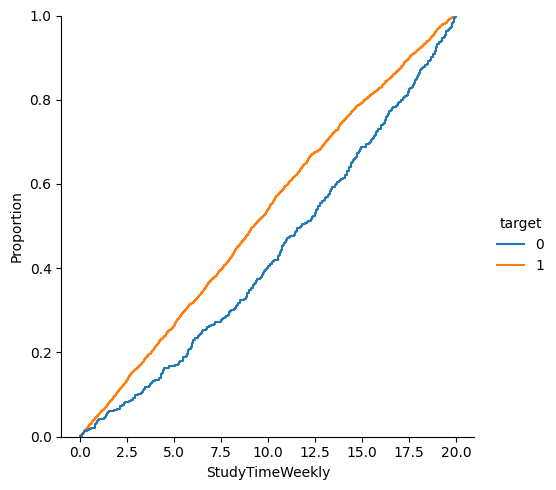

In [77]:
sns.displot(data=data, x="StudyTimeWeekly", hue="target", kind = "ecdf")


En este caso podemos ver algo que no sería intuitivo, y es que los alumnos que han aprobado, han dedicado de media, menos horas al estudio que aquellos que han suspendido. Una posible lectura podría ser que saber rentabilizar más el tiempo de estudio.

In [83]:

print("Numero de estudiantes, numero y porcentaje de estudiantes que realizan extraescolares por calificación")
data.groupby("target")["Extracurricular"].agg(["count","sum","mean"])

Numero de estudiantes, numero y porcentaje de estudiantes que realizan extraescolares por calificación


,count,sum,mean
target,,,
0,376,168,0.446809
1,2016,749,0.371528


En este caso vemos como en aquellos que han suspendido, un 44% asistia a extraescolares, mientras que el porcentaje era de un 37% para los que han aprobado.

In [84]:


print("Numero de estudiantes, numero y porcentaje de estudiantes que aprueban en base al apoyo de los padres")
data.groupby("ParentalSupport")["target"].agg(["count","sum","mean"])

Numero de estudiantes, numero y porcentaje de estudiantes que realizan extraescolares por calificación


,count,sum,mean
ParentalSupport,,,
0,212,199,0.938679
1,489,436,0.891616
2,740,627,0.847297
3,697,558,0.800574
4,254,196,0.771654


En este caso, nos volvemos a encontrar algo contraintuitivo, y es que cuanto más ayuda reciben de los padres, peor resultado obtienen de media.

# Modelo

In [136]:
import xgboost as xgb
import bctools as bc

model = xgb.XGBClassifier()

# En este caso, yo voy a usar las siguientes covariables. Puedes comprobar a añadir/quitar variables y observar si el resultado varia
model.fit(X_train[["Gender",	"ParentalEducation",	"StudyTimeWeekly",	"Absences",	"Tutoring",	"treatment",	"Extracurricular"]], y_train)

#Making predictions on the test set
predictions_train_proba = model.predict_proba(X_train[["Gender",	"ParentalEducation",	"StudyTimeWeekly",	"Absences",	"Tutoring",	"treatment",	"Extracurricular"]])[:,1]
predictions_test_proba = model.predict_proba(X_test[["Gender",	"ParentalEducation",	"StudyTimeWeekly",	"Absences",	"Tutoring",	"treatment",	"Extracurricular"]])[:,1]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

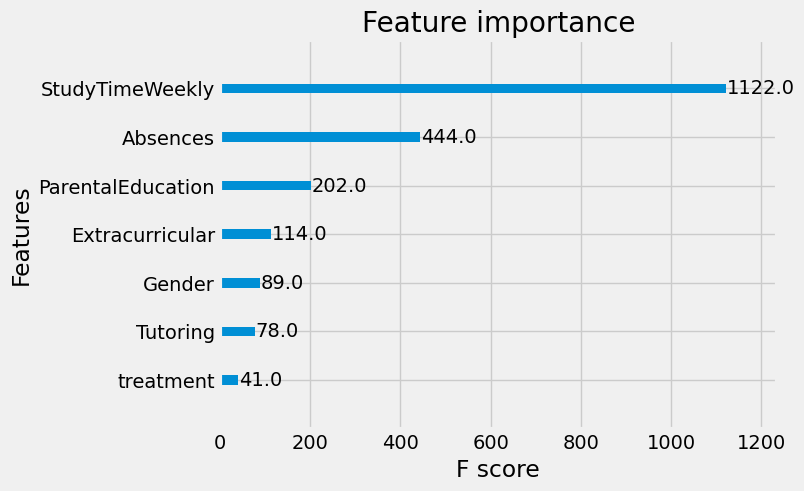

In [137]:
xgb.plot_importance(model)


In [120]:
cf_fig, var_metrics_df, invar_metrics_df, opt_thresh_df = bc.confusion_matrix_plot(
    true_y = y_test,
    predicted_proba = predictions_test_proba,
    threshold_step = 0.05,
    title = 'Interactive Confusion Matrix for the Training Set')
cf_fig

Si queremos ver de forma más intuitiva como se distribuyen los aprobados / suspensos en base a la probabilidad asignada, podemos verlo con el siguiente comando

In [121]:

curve_type = 'kde' #'kde' is the default value, can also be set to 'normal'

density_curve_kde = bc.predicted_proba_density_curve_plot(true_y = y_test,
                                                          predicted_proba = predictions_test_proba,
                                                          threshold_step = 0.05,
                                                          curve_type = curve_type)
density_curve_kde

Visto lo previo, parece que nuestro modelo detecta muy bien a los aprobados, pero los suspensos se distribuyen casi uniformemente a lo largo de las probabilidades.

# Calculo de uplifts scores

Ahora usaremos el modelo anterior para predecir fijando la variable a 0 y despues, fijando la variable 1.

In [126]:
X_test["treatment"] = 1
predictions_test_treat_proba = model.predict_proba(X_test[["Gender",	"ParentalEducation",	"StudyTimeWeekly",	"Absences",	"Tutoring",	"treatment",	"Extracurricular"]])[:,1]
X_test["treatment"] = 0
predictions_test_no_treat_proba = model.predict_proba(X_test[["Gender",	"ParentalEducation",	"StudyTimeWeekly",	"Absences",	"Tutoring",	"treatment",	"Extracurricular"]])[:,1]


uplifts_scores = predictions_test_treat_proba - predictions_test_no_treat_proba


Ya tenemos estimado el efecto que tendría el tratamiento en cada alumno. Veamos como se distribuye:

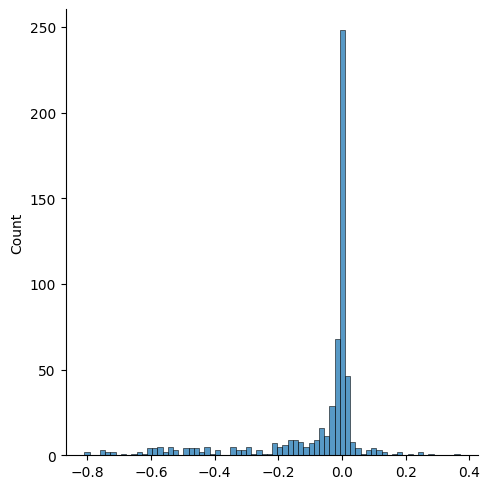

In [127]:
sns.displot(x = uplifts_scores)

Si vemos la distribución, vemos como en la gran mayoria, no afectará a la probabilidad del alumno, pero más curioso es el que parece que en los casos donde sí que afecta, emeora la probabilidad de aprobar. Con estos datos en la mano, no optaremos por recomendar a los padres ese esfuerzo extra.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)


In [135]:
learner_s = BaseSRegressor(model)
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(
    X=X_test[["Gender",	"ParentalEducation",	"StudyTimeWeekly",	"Absences",	"Tutoring",	"treatment",	"Extracurricular"]],
    treatment=X_test["treatment"],
    y=y_test,
    return_ci=True,
    bootstrap_ci=False
    )

print(f"Estimacion del ATE (banda superior): {ate_s_ub}")
print(f"Estimacion del ATE: {ate_s}")
print(f"Estimacion del ATE (banda inferior): {ate_s_lb}")

Estimacion del ATE (banda superior): [0.00997935]
Estimacion del ATE: [0.]
Estimacion del ATE (banda inferior): [-0.00997935]


En vistas de que la variable más importante en el modelo, es el tiempo de estudio, podriamos considerar crear la varible "estudiar mucho tiempo" como variable tratamiento y ver como afecta.